# Network Graph

This code makes a graph of the boilogical pathways in the Reactome database. Each biological pathway (each node) represents a process that involves at least one protein, and up to multiple complexes. This code takes that information and color codes it according to our cancer dataset. Nodes that contained at least one differentially expressed protein in cancer are colored red, nodes that contained no differentially expressed proteins were colored blue, and nodes for which we have no data are colored black.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Import libraries, assign global variables, and read in supplementary data
ReactomePathwaysRelation.txt was downloaded from Reactome.org: https://reactome.org/download/current/ReactomePathwaysRelation.txt

pathwayPositionJsonDataPath was created using Cytoscope: https://cytoscape.org/. We loaded the network into cytosape, performed one of their layout transformatins, and then downloaded the graph as this JSON file.

differentiallyExpressedPathways.pickle and notDifferentiallyExpressedPathways.pickle were generated with the following code: https://colab.research.google.com/drive/1d5j7xruuUjnUxF_eXrIw67-nlN2JyHn8, which in turn used data generaetd from the folowing code: https://colab.research.google.com/drive/19YNORCVwowXRz3WtGo6r3rUmbSFiog6y

In [0]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np

red = "#FF0000"
blue = "#0000FF"
black = "#000000"

import pickle
diffPathway = pickle.load(open("differentiallyExpressedPathways.pickle", "rb"))
noDiffPathway = pickle.load(open("notDifferentiallyExpressedPathways.pickle", "rb"))
cancerDataPath = 'ReactomePathwaysRelation.txt'
pathwayPositionJsonDataPath = 'test.gml.cyjs'

#### Read in and prepare the data

In [0]:


# read in dataframe
df = pd.read_csv(cancerDataPath, sep="\t")

# add headers to the data frame
headers = ["Parent","Child"]
df.columns = headers

# keep only HSA rows --------------------------------

Parents = df["Parent"]
Children = df["Child"]

# grab the names of R-HSA- pathways
pathways = []
for pathway in Parents:
    if pathway.startswith("R-HSA-"):
        pathways.append(pathway)
for pathway in Children:
    if pathway.startswith("R-HSA-"):
        pathways.append(pathway)

        # make unique
pathways = list(set(pathways))

# remove non-R-HSA pathways
df = df[df["Parent"].isin(pathways)]
df = df[df["Child"].isin(pathways)]


#### read in node positions for graph

In [0]:
data = {}
with open(pathwayPositionJsonDataPath) as jsonFile:
    data = json.load(jsonFile)


nodeList = []
positions = {}
for node in data['elements']['nodes']:
    nodeName = node['data']['name']
    x = node['position']['x']
    y = node['position']['y']
    positions[nodeName] = np.asarray([x,y])

#### load data into graph

In [0]:
# make the graph
G = nx.DiGraph()


# add nodes -------------------------------------------
G.add_nodes_from(pathways)


# add edges -------------------------------------------


baseShape = 10
nodeSizes = {}
# MAKE THE GRAPH (and store information along the way)
for index, row in df.iterrows():
    # STORE EDGE COLORS *************************
    edgeColor = None
    if row[0] in diffPathway:
        edgeColor = red
    elif row[0] in noDiffPathway:
        edgeColor = blue
    else:
        edgeColor = black
    # ADD EDGES TO GRAPH ************************
    G.add_edge(row[0], row[1])

#### Get colors for nodes and edges

In [0]:
# Grab information from the graph ----------------------

# Get colors of each node ******************************
colors = []

for node in G.nodes:
    if node in diffPathway:
        colors.append(red)
    elif node in noDiffPathway:
        colors.append(blue)
    else:
        colors.append(black)


# MAKE THE COLORS OF EDGES *******************************
edge_colors = []
for edge in G.edges:
    # print(edge[0])
    edgeColor = None
    if edge[1] in diffPathway:
        edgeColor = red
    elif edge[1] in noDiffPathway:
        edgeColor = blue
    else:
        edgeColor = black
    edge_colors.append(edgeColor)


#### make the graph
Notice that some edges' colors do not match their source nodes. This is useful because it only occurs in cases where the child node does not match the color of the parent. It can therefore point out hierarchies where an overabundance in one parent did not propogate to the children.

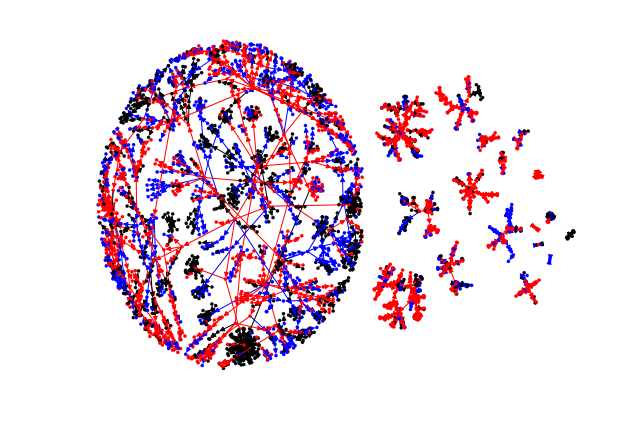

In [0]:

#  plot it ---------------------------------------------
nx.draw(G,pos=positions,show_labels=False,node_color=colors, node_size=10, edge_color = edge_colors)
plt.show()